In [ ]:
from torch.autograd import Variable
import numpy as np
import tensorflow as tf
import time, math, glob
import scipy.io as sio
import torch
import torch.nn as nn
from math import sqrt
import argparse, os
import torch
import random
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import h5py

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import os
import copy


In [ ]:
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from PIL.ImageOps import colorize

In [ ]:
import h5py as h5py
import numpy as np
import tensorflow as tf
from sklearn import metrics
import torchvision.models as models
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Colab Notebooks',
 'content',
 'drive',
 'train',
 'validation',
 'Cifar10(half-half)_128_lr=0.05_epochs=50.h5',
 'Cifar10(half-half)_128_lr=0.05_epochs=50.h5（副本）',
 'checkpoint',
 'Cifar10_Aug',
 'merged_Cifar10(origin)_128_lr=0.002_epochs=100.h5',
 '0',
 '5',
 'tensorboard',
 'Cifar10_split',
 'TIP Moire Pattern Removal',
 'data']

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(128),
        transforms.RandomRotation(20),
        transforms.ColorJitter(),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(128),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = '/content/drive/MyDrive/Cifar10-VDSR(256)_split'
data_dir = '/content/drive/MyDrive/Cifar10_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=8, drop_last=True)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return residual,out

def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list))]
    layers += [nn.MaxPool2d(kernel_size=pooling_k, stride=pooling_s)]
    return nn.Sequential(*layers)

class SDCNN(nn.Module):
    def __init__(self, n_classes=10):
        super(SDCNN, self).__init__()

        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([3,32], [32,32], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([32,64], [64,64], [3,3], [1,1], 2, 2)

        # FC layers
        self.layer3 = vgg_fc_layer(32*32*64, 512)  # 4096->smaller

        # Final layer
        self.layer4 = nn.Linear(512, 10)

    def forward(self, x):
        # 从这里开始
        out = self.layer1(x)
        features = self.layer2(out)
        out = features.view(out.size(0), -1)
        out = self.layer3(out)
        out = self.layer4(out)

        return out


Namespace(SR_used=True, SRtrain=True, TLtrain=False, clip=0.4, cuda=False, gpus='0', lr=0.0001, momentum=0.9, nEpochs=50, pretrained_SR='/content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_31.pth', pretrained_SR_num=0, pretrained_TL='/content/drive/MyDrive/checkpoint/TransferLearning/model_CNET_epoch_31.pth', pretrained_TL_num=0, resume='', start_epoch=1, step=10, threads=1, weight_decay=0.0001)
Random Seed:  9611
===> Loading datasets
===> Building model
===> Setting GPU
=> loading SR model '/content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_31.pth'
=> loading TL model '/content/drive/MyDrive/checkpoint/TransferLearning/model_CNET_epoch_31.pth'
===> Setting Optimizer
===> Training
Epoch = 1, lr = 0.0001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


===> Average Loss: 0.9131169066
===> Average Loss: 0.8749262781
===> Average Loss: 0.8664569796
===> Average Loss: 0.8698113715
===> Average Loss: 0.8847865652
===> Average Loss: 0.8877818735
===> Average Loss: 0.8836628719
===> Average Loss: 0.8759456946
===> Average Loss: 0.8799168416
===> Average Loss: 0.8772210339
===> Average Loss: 0.8802529503
===> Average Loss: 0.8795076180
===> Average Loss: 0.8719302889
===> Average Loss: 0.8745347315
===> Average Loss: 0.8753356610
===> Average Loss: 0.8756346031
===> Average Loss: 0.8735953904
===> Average Loss: 0.8731749385
===> Average Loss: 0.8714440203
===> Average Loss: 0.8727138262
===> Average Loss: 0.8732599869
===> Average Loss: 0.8732327877
===> Average Loss: 0.8720296651
===> Average Loss: 0.8705284137
===> Average Loss: 0.8709843041


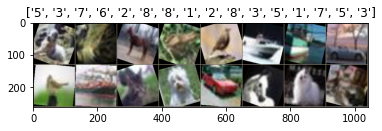

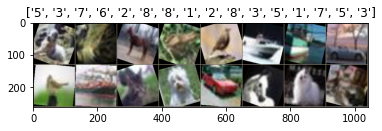

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_1.pth
Epoch = 2, lr = 0.0001
===> Average Loss: 0.8303686655
===> Average Loss: 0.8442616665
===> Average Loss: 0.8468105844
===> Average Loss: 0.8535796814
===> Average Loss: 0.8580422756
===> Average Loss: 0.8595814346
===> Average Loss: 0.8611040838
===> Average Loss: 0.8624487974
===> Average Loss: 0.8644605051
===> Average Loss: 0.8631147954
===> Average Loss: 0.8654691615
===> Average Loss: 0.8648172546
===> Average Loss: 0.8671117913
===> Average Loss: 0.8658034152
===> Average Loss: 0.8663912725
===> Average Loss: 0.8651220073
===> Average Loss: 0.8641708274
===> Average Loss: 0.8655059715
===> Average Loss: 0.8665549481
===> Average Loss: 0.8662880930
===> Average Loss: 0.8649553649
===> Average Loss: 0.8664985911
===> Average Loss: 0.8647959975
===> Average Loss: 0.8661247126
===> Average Loss: 0.8669214251


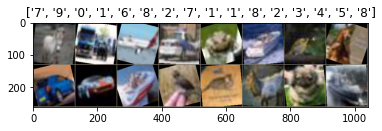

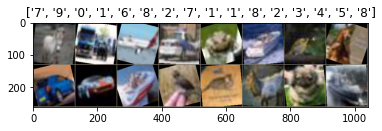

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_2.pth
Epoch = 3, lr = 0.0001
===> Average Loss: 0.9100193793
===> Average Loss: 0.8914063627
===> Average Loss: 0.8932016889
===> Average Loss: 0.8942701078
===> Average Loss: 0.8886710413
===> Average Loss: 0.8908855909
===> Average Loss: 0.8858456017
===> Average Loss: 0.8802149422
===> Average Loss: 0.8744405197
===> Average Loss: 0.8746244462
===> Average Loss: 0.8730824780
===> Average Loss: 0.8701027100
===> Average Loss: 0.8686784917
===> Average Loss: 0.8703056413
===> Average Loss: 0.8689905177
===> Average Loss: 0.8701503305
===> Average Loss: 0.8692531179
===> Average Loss: 0.8702891686
===> Average Loss: 0.8691856764
===> Average Loss: 0.8692581198
===> Average Loss: 0.8728947562
===> Average Loss: 0.8698396885
===> Average Loss: 0.8686955879
===> Average Loss: 0.8705077997
===> Average Loss: 0.8690881837


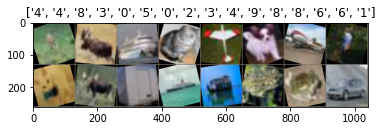

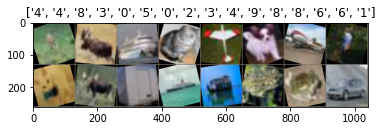

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_3.pth
Epoch = 4, lr = 0.0001
===> Average Loss: 0.8986485413
===> Average Loss: 0.8802523693
===> Average Loss: 0.8624891549
===> Average Loss: 0.8683638585
===> Average Loss: 0.8698438613
===> Average Loss: 0.8694879298
===> Average Loss: 0.8734009489
===> Average Loss: 0.8772637143
===> Average Loss: 0.8750342883
===> Average Loss: 0.8731984823
===> Average Loss: 0.8712830261
===> Average Loss: 0.8717511538
===> Average Loss: 0.8768934453
===> Average Loss: 0.8771567313
===> Average Loss: 0.8784347111
===> Average Loss: 0.8774498076
===> Average Loss: 0.8778361700
===> Average Loss: 0.8772660382
===> Average Loss: 0.8783442344
===> Average Loss: 0.8776178539
===> Average Loss: 0.8769830650
===> Average Loss: 0.8759839675
===> Average Loss: 0.8757545327
===> Average Loss: 0.8733342485
===> Average Loss: 0.8735201607


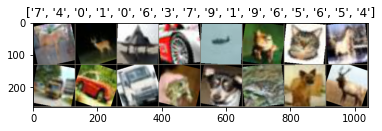

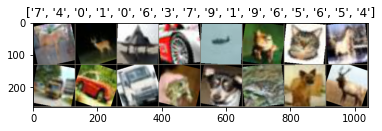

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_4.pth
Epoch = 5, lr = 0.0001
===> Average Loss: 0.8254463026
===> Average Loss: 0.8455359705
===> Average Loss: 0.8542563485
===> Average Loss: 0.8603691947
===> Average Loss: 0.8612106667
===> Average Loss: 0.8687287279
===> Average Loss: 0.8665636516
===> Average Loss: 0.8665758859
===> Average Loss: 0.8734005803
===> Average Loss: 0.8723841150
===> Average Loss: 0.8715181933
===> Average Loss: 0.8734639761
===> Average Loss: 0.8729808162
===> Average Loss: 0.8744061232
===> Average Loss: 0.8758383203
===> Average Loss: 0.8759666805
===> Average Loss: 0.8715890416
===> Average Loss: 0.8711746129
===> Average Loss: 0.8685891846
===> Average Loss: 0.8674035656
===> Average Loss: 0.8666313011
===> Average Loss: 0.8665307975
===> Average Loss: 0.8674768599
===> Average Loss: 0.8683531967
===> Average Loss: 0.8682785266


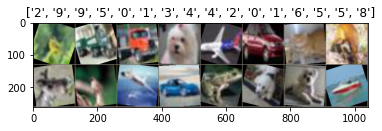

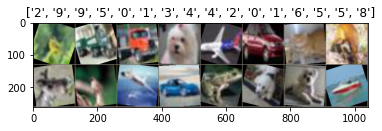

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_5.pth
Epoch = 6, lr = 0.0001
===> Average Loss: 0.8897154111
===> Average Loss: 0.8801258837
===> Average Loss: 0.8848587184
===> Average Loss: 0.8873880445
===> Average Loss: 0.8788821591
===> Average Loss: 0.8720015304
===> Average Loss: 0.8710458022
===> Average Loss: 0.8693906126
===> Average Loss: 0.8681892411
===> Average Loss: 0.8663571826
===> Average Loss: 0.8652125854
===> Average Loss: 0.8659106585
===> Average Loss: 0.8685302955
===> Average Loss: 0.8697158700
===> Average Loss: 0.8707998369
===> Average Loss: 0.8680992538
===> Average Loss: 0.8698597132
===> Average Loss: 0.8697710666
===> Average Loss: 0.8677356793
===> Average Loss: 0.8645589429
===> Average Loss: 0.8649617412
===> Average Loss: 0.8666271334
===> Average Loss: 0.8673240700
===> Average Loss: 0.8681561021
===> Average Loss: 0.8691393415


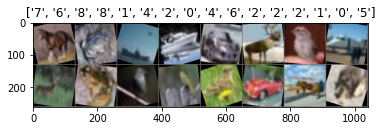

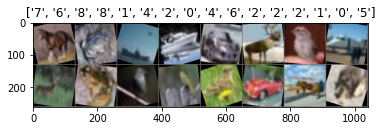

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_6.pth
Epoch = 7, lr = 0.0001
===> Average Loss: 0.8802550018
===> Average Loss: 0.8838246414
===> Average Loss: 0.8755028641
===> Average Loss: 0.8796526477
===> Average Loss: 0.8721481090
===> Average Loss: 0.8676654636
===> Average Loss: 0.8690183721
===> Average Loss: 0.8701819732
===> Average Loss: 0.8772154969
===> Average Loss: 0.8776479842
===> Average Loss: 0.8743178271
===> Average Loss: 0.8732474233
===> Average Loss: 0.8702114226
===> Average Loss: 0.8692139366
===> Average Loss: 0.8673018008
===> Average Loss: 0.8661826682
===> Average Loss: 0.8666303114
===> Average Loss: 0.8674987315
===> Average Loss: 0.8671458510
===> Average Loss: 0.8658262946
===> Average Loss: 0.8695414015
===> Average Loss: 0.8694541693
===> Average Loss: 0.8681759270
===> Average Loss: 0.8687650425
===> Average Loss: 0.8683253693


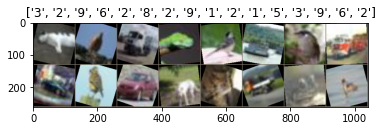

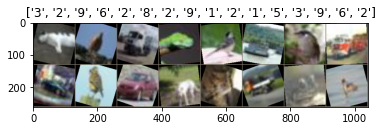

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_7.pth
Epoch = 8, lr = 0.0001
===> Average Loss: 0.8865910411
===> Average Loss: 0.8738360377
===> Average Loss: 0.8661614913
===> Average Loss: 0.8734739645
===> Average Loss: 0.8682729280
===> Average Loss: 0.8668057703
===> Average Loss: 0.8680344953
===> Average Loss: 0.8707221149
===> Average Loss: 0.8696786070
===> Average Loss: 0.8661147586
===> Average Loss: 0.8680067273
===> Average Loss: 0.8670628251
===> Average Loss: 0.8650364521
===> Average Loss: 0.8631030551
===> Average Loss: 0.8647669725
===> Average Loss: 0.8653741840
===> Average Loss: 0.8665478465
===> Average Loss: 0.8659182870
===> Average Loss: 0.8647550495
===> Average Loss: 0.8663987067
===> Average Loss: 0.8658336215
===> Average Loss: 0.8666176582
===> Average Loss: 0.8670919425
===> Average Loss: 0.8676079654
===> Average Loss: 0.8671468153


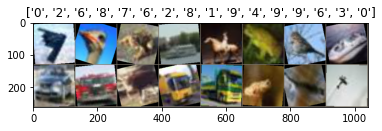

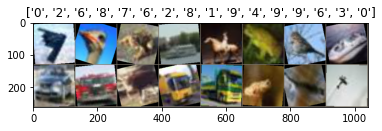

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_8.pth
Epoch = 9, lr = 0.0001
===> Average Loss: 0.8807349640
===> Average Loss: 0.8645958120
===> Average Loss: 0.8586213115
===> Average Loss: 0.8621872813
===> Average Loss: 0.8606009734
===> Average Loss: 0.8600940365
===> Average Loss: 0.8614205694
===> Average Loss: 0.8607585129
===> Average Loss: 0.8620115018
===> Average Loss: 0.8638473549
===> Average Loss: 0.8664397632
===> Average Loss: 0.8662693521
===> Average Loss: 0.8684246832
===> Average Loss: 0.8660894308
===> Average Loss: 0.8675028412
===> Average Loss: 0.8678757425
===> Average Loss: 0.8639524573
===> Average Loss: 0.8642050504
===> Average Loss: 0.8635589879
===> Average Loss: 0.8643682299
===> Average Loss: 0.8640334830
===> Average Loss: 0.8644855548
===> Average Loss: 0.8641636543
===> Average Loss: 0.8637130089
===> Average Loss: 0.8638957697


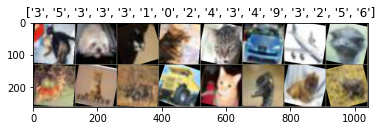

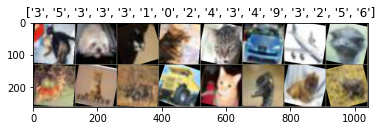

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_9.pth
Epoch = 10, lr = 0.0001
===> Average Loss: 0.8552327633
===> Average Loss: 0.8832298583
===> Average Loss: 0.8642171739
===> Average Loss: 0.8593862219
===> Average Loss: 0.8570838518
===> Average Loss: 0.8598022404
===> Average Loss: 0.8597089893
===> Average Loss: 0.8580364487
===> Average Loss: 0.8592271443
===> Average Loss: 0.8666569857
===> Average Loss: 0.8637545446
===> Average Loss: 0.8655135594
===> Average Loss: 0.8665566235
===> Average Loss: 0.8668567595
===> Average Loss: 0.8674865433
===> Average Loss: 0.8701101472
===> Average Loss: 0.8729543247
===> Average Loss: 0.8719487222
===> Average Loss: 0.8714797921
===> Average Loss: 0.8707750363
===> Average Loss: 0.8705592807
===> Average Loss: 0.8700440731
===> Average Loss: 0.8730159249
===> Average Loss: 0.8731699918
===> Average Loss: 0.8727635680


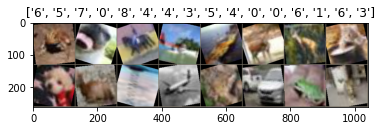

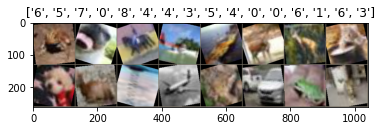

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_10.pth
Epoch = 11, lr = 1e-05
===> Average Loss: 0.8551610473
===> Average Loss: 0.8526151314
===> Average Loss: 0.8491140653
===> Average Loss: 0.8548916464
===> Average Loss: 0.8570955530
===> Average Loss: 0.8586277023
===> Average Loss: 0.8543867055
===> Average Loss: 0.8562389636
===> Average Loss: 0.8633298184
===> Average Loss: 0.8606483437
===> Average Loss: 0.8612748550
===> Average Loss: 0.8623079760
===> Average Loss: 0.8629906131
===> Average Loss: 0.8625612231
===> Average Loss: 0.8631211697
===> Average Loss: 0.8650562427
===> Average Loss: 0.8639315247
===> Average Loss: 0.8622352363
===> Average Loss: 0.8620406383
===> Average Loss: 0.8632898702
===> Average Loss: 0.8613799325
===> Average Loss: 0.8627104788
===> Average Loss: 0.8643800319
===> Average Loss: 0.8653119900
===> Average Loss: 0.8666514702


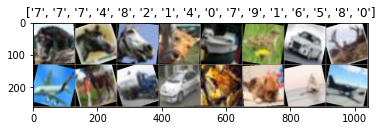

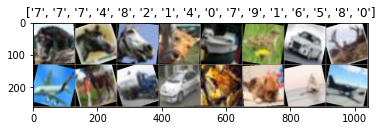

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_11.pth
Epoch = 12, lr = 1e-05
===> Average Loss: 0.8856592357
===> Average Loss: 0.8558537096
===> Average Loss: 0.8347187145
===> Average Loss: 0.8423720741
===> Average Loss: 0.8472714428
===> Average Loss: 0.8418626600
===> Average Loss: 0.8493727141
===> Average Loss: 0.8530457393
===> Average Loss: 0.8570811409
===> Average Loss: 0.8601471049
===> Average Loss: 0.8649319234
===> Average Loss: 0.8647207126
===> Average Loss: 0.8657677772
===> Average Loss: 0.8648392818
===> Average Loss: 0.8655701426
===> Average Loss: 0.8619782904
===> Average Loss: 0.8629720819
===> Average Loss: 0.8626832980
===> Average Loss: 0.8614865662
===> Average Loss: 0.8657265983
===> Average Loss: 0.8652365150
===> Average Loss: 0.8658609736
===> Average Loss: 0.8662604036
===> Average Loss: 0.8667315777
===> Average Loss: 0.8676356333


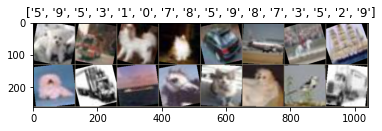

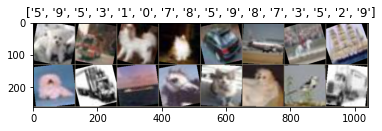

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_12.pth
Epoch = 13, lr = 1e-05
===> Average Loss: 0.9066188616
===> Average Loss: 0.8837196390
===> Average Loss: 0.8708714800
===> Average Loss: 0.8736698873
===> Average Loss: 0.8737375720
===> Average Loss: 0.8690659697
===> Average Loss: 0.8692415032
===> Average Loss: 0.8701932439
===> Average Loss: 0.8707893853
===> Average Loss: 0.8677882952
===> Average Loss: 0.8708510940
===> Average Loss: 0.8710196733
===> Average Loss: 0.8708380796
===> Average Loss: 0.8694850797
===> Average Loss: 0.8703298334
===> Average Loss: 0.8699632138
===> Average Loss: 0.8707189897
===> Average Loss: 0.8698329407
===> Average Loss: 0.8696951356
===> Average Loss: 0.8714832852
===> Average Loss: 0.8713082159
===> Average Loss: 0.8701116733
===> Average Loss: 0.8709528560
===> Average Loss: 0.8710156400
===> Average Loss: 0.8728704449


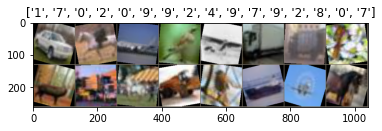

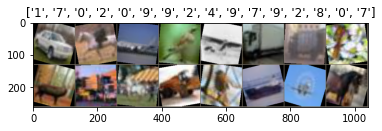

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_13.pth
Epoch = 14, lr = 1e-05
===> Average Loss: 0.8807884201
===> Average Loss: 0.8626806928
===> Average Loss: 0.8537619433
===> Average Loss: 0.8594364708
===> Average Loss: 0.8641133539
===> Average Loss: 0.8654346097
===> Average Loss: 0.8657206829
===> Average Loss: 0.8672942471
===> Average Loss: 0.8658604229
===> Average Loss: 0.8640496831
===> Average Loss: 0.8664228651
===> Average Loss: 0.8670239481
===> Average Loss: 0.8642269733
===> Average Loss: 0.8643699342
===> Average Loss: 0.8660167567
===> Average Loss: 0.8670393164
===> Average Loss: 0.8678914781
===> Average Loss: 0.8685273699
===> Average Loss: 0.8699211311
===> Average Loss: 0.8701302526
===> Average Loss: 0.8714976739
===> Average Loss: 0.8712809425
===> Average Loss: 0.8704119698
===> Average Loss: 0.8678386640
===> Average Loss: 0.8671833774


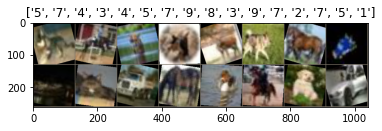

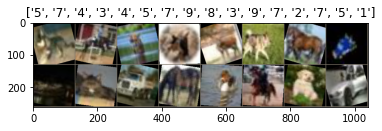

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_14.pth
Epoch = 15, lr = 1e-05
===> Average Loss: 0.8474858439
===> Average Loss: 0.8547485664
===> Average Loss: 0.8543893745
===> Average Loss: 0.8482995067
===> Average Loss: 0.8571602549
===> Average Loss: 0.8579770297
===> Average Loss: 0.8596387027
===> Average Loss: 0.8657971692
===> Average Loss: 0.8714514277
===> Average Loss: 0.8698777549
===> Average Loss: 0.8697012209
===> Average Loss: 0.8681841416
===> Average Loss: 0.8702063670
===> Average Loss: 0.8735242637
===> Average Loss: 0.8732091826
===> Average Loss: 0.8744798126
===> Average Loss: 0.8745209097
===> Average Loss: 0.8710853304
===> Average Loss: 0.8705777039
===> Average Loss: 0.8693592538
===> Average Loss: 0.8693856860
===> Average Loss: 0.8695447432
===> Average Loss: 0.8691941230
===> Average Loss: 0.8698112621
===> Average Loss: 0.8698820509


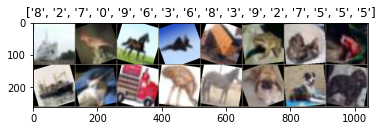

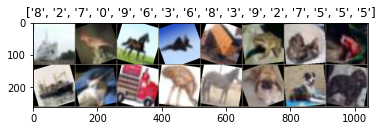

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_15.pth
Epoch = 16, lr = 1e-05
===> Average Loss: 0.8330538243
===> Average Loss: 0.8452391924
===> Average Loss: 0.8558687928
===> Average Loss: 0.8611246944
===> Average Loss: 0.8619682779
===> Average Loss: 0.8660553762
===> Average Loss: 0.8633475857
===> Average Loss: 0.8615172898
===> Average Loss: 0.8637167137
===> Average Loss: 0.8669136600
===> Average Loss: 0.8688342682
===> Average Loss: 0.8667918728
===> Average Loss: 0.8661111329
===> Average Loss: 0.8660541025
===> Average Loss: 0.8620857676
===> Average Loss: 0.8647543685
===> Average Loss: 0.8649263433
===> Average Loss: 0.8624693149
===> Average Loss: 0.8626853654
===> Average Loss: 0.8632773280
===> Average Loss: 0.8631154673
===> Average Loss: 0.8632092809
===> Average Loss: 0.8658570994
===> Average Loss: 0.8665957610
===> Average Loss: 0.8649278513


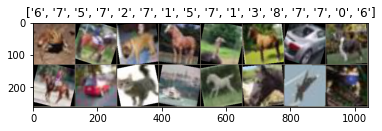

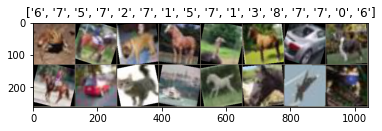

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_16.pth
Epoch = 17, lr = 1e-05
===> Average Loss: 0.8825450400
===> Average Loss: 0.8728833361
===> Average Loss: 0.8610211752
===> Average Loss: 0.8617816393
===> Average Loss: 0.8623077743
===> Average Loss: 0.8637986392
===> Average Loss: 0.8618262258
===> Average Loss: 0.8613757956
===> Average Loss: 0.8626869305
===> Average Loss: 0.8615866635
===> Average Loss: 0.8608239308
===> Average Loss: 0.8621386297
===> Average Loss: 0.8665369219
===> Average Loss: 0.8648129584
===> Average Loss: 0.8692484597
===> Average Loss: 0.8695997371
===> Average Loss: 0.8688228566
===> Average Loss: 0.8695172370
===> Average Loss: 0.8680893899
===> Average Loss: 0.8687058483
===> Average Loss: 0.8690976893
===> Average Loss: 0.8662272037
===> Average Loss: 0.8647306099
===> Average Loss: 0.8653747021
===> Average Loss: 0.8644009382


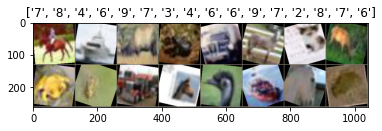

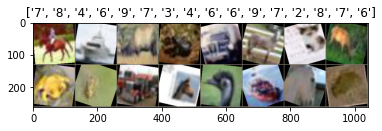

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_17.pth
Epoch = 18, lr = 1e-05
===> Average Loss: 0.8604202127
===> Average Loss: 0.8550163233
===> Average Loss: 0.8619163630
===> Average Loss: 0.8560820198
===> Average Loss: 0.8546394218
===> Average Loss: 0.8552790998
===> Average Loss: 0.8596812605
===> Average Loss: 0.8559954561
===> Average Loss: 0.8568419096
===> Average Loss: 0.8574058532
===> Average Loss: 0.8616457951
===> Average Loss: 0.8652385339
===> Average Loss: 0.8651929686
===> Average Loss: 0.8642469501
===> Average Loss: 0.8663462271
===> Average Loss: 0.8672344626
===> Average Loss: 0.8683363876
===> Average Loss: 0.8691611049
===> Average Loss: 0.8684340224
===> Average Loss: 0.8673784928
===> Average Loss: 0.8690485959
===> Average Loss: 0.8665574510
===> Average Loss: 0.8656239234
===> Average Loss: 0.8653193597
===> Average Loss: 0.8654847731


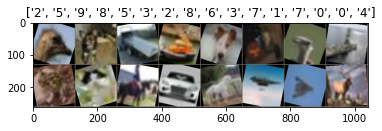

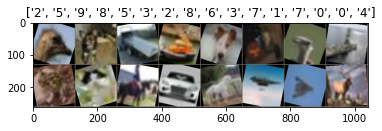

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_18.pth
Epoch = 19, lr = 1e-05
===> Average Loss: 0.8607528460
===> Average Loss: 0.8766329190
===> Average Loss: 0.8795296109
===> Average Loss: 0.8759792334
===> Average Loss: 0.8781848227
===> Average Loss: 0.8773785732
===> Average Loss: 0.8763161199
===> Average Loss: 0.8715193117
===> Average Loss: 0.8693628204
===> Average Loss: 0.8701852472
===> Average Loss: 0.8700002868
===> Average Loss: 0.8691339107
===> Average Loss: 0.8708922462
===> Average Loss: 0.8719147232
===> Average Loss: 0.8695923667
===> Average Loss: 0.8704566302
===> Average Loss: 0.8697173053
===> Average Loss: 0.8710709181
===> Average Loss: 0.8710727987
===> Average Loss: 0.8726150277
===> Average Loss: 0.8751409633
===> Average Loss: 0.8747995698
===> Average Loss: 0.8757241713
===> Average Loss: 0.8752225026
===> Average Loss: 0.8754104277


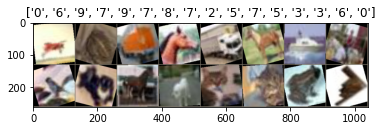

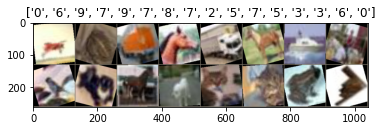

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_19.pth
Epoch = 20, lr = 1e-05
===> Average Loss: 0.8818569392
===> Average Loss: 0.8933034666
===> Average Loss: 0.8978210375
===> Average Loss: 0.8822704296
===> Average Loss: 0.8710326927
===> Average Loss: 0.8626912696
===> Average Loss: 0.8641417939
===> Average Loss: 0.8665720788
===> Average Loss: 0.8643019823
===> Average Loss: 0.8649887428
===> Average Loss: 0.8633284593
===> Average Loss: 0.8644115348
===> Average Loss: 0.8648867716
===> Average Loss: 0.8690713111
===> Average Loss: 0.8678107664
===> Average Loss: 0.8674911798
===> Average Loss: 0.8688136253
===> Average Loss: 0.8698315502
===> Average Loss: 0.8686724938
===> Average Loss: 0.8698779388
===> Average Loss: 0.8686823236
===> Average Loss: 0.8689148020
===> Average Loss: 0.8693686120
===> Average Loss: 0.8682100586
===> Average Loss: 0.8683060596


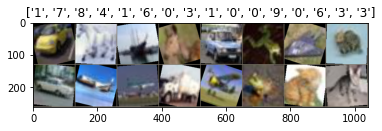

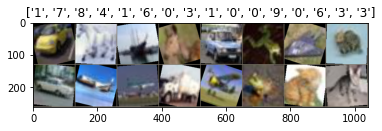

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_20.pth
Epoch = 21, lr = 1.0000000000000002e-06
===> Average Loss: 0.8075866166
===> Average Loss: 0.8505389586
===> Average Loss: 0.8611538962
===> Average Loss: 0.8499757595
===> Average Loss: 0.8575987273
===> Average Loss: 0.8676086318
===> Average Loss: 0.8732620193
===> Average Loss: 0.8721164665
===> Average Loss: 0.8689487694
===> Average Loss: 0.8671654092
===> Average Loss: 0.8643555910
===> Average Loss: 0.8639164039
===> Average Loss: 0.8624396338
===> Average Loss: 0.8619489518
===> Average Loss: 0.8614536072
===> Average Loss: 0.8627178679
===> Average Loss: 0.8613759636
===> Average Loss: 0.8644889365
===> Average Loss: 0.8654777154
===> Average Loss: 0.8659021658
===> Average Loss: 0.8658832048
===> Average Loss: 0.8666957981
===> Average Loss: 0.8669196154
===> Average Loss: 0.8648567855
===> Average Loss: 0.8648692159


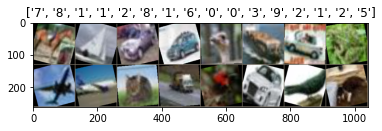

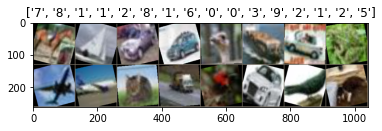

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_21.pth
Epoch = 22, lr = 1.0000000000000002e-06
===> Average Loss: 0.8575062010
===> Average Loss: 0.8528572948
===> Average Loss: 0.8704962853
===> Average Loss: 0.8730680375
===> Average Loss: 0.8772360117
===> Average Loss: 0.8708109778
===> Average Loss: 0.8694275192
===> Average Loss: 0.8693562149
===> Average Loss: 0.8673864630
===> Average Loss: 0.8643462810
===> Average Loss: 0.8659178857
===> Average Loss: 0.8662262579
===> Average Loss: 0.8676362836
===> Average Loss: 0.8649685062
===> Average Loss: 0.8621620891
===> Average Loss: 0.8642561727
===> Average Loss: 0.8636564494
===> Average Loss: 0.8652402948
===> Average Loss: 0.8662308439
===> Average Loss: 0.8659760354
===> Average Loss: 0.8651607982
===> Average Loss: 0.8639911155
===> Average Loss: 0.8660821360
===> Average Loss: 0.8676482334
===> Average Loss: 0.8689337523


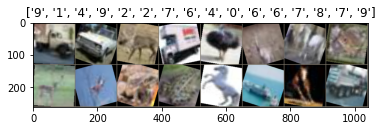

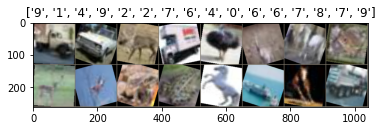

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_22.pth
Epoch = 23, lr = 1.0000000000000002e-06
===> Average Loss: 0.8713423577
===> Average Loss: 0.8585506549
===> Average Loss: 0.8688458178
===> Average Loss: 0.8622783756
===> Average Loss: 0.8600503419
===> Average Loss: 0.8560960509
===> Average Loss: 0.8564004054
===> Average Loss: 0.8610439231
===> Average Loss: 0.8599529528
===> Average Loss: 0.8583066523
===> Average Loss: 0.8600651280
===> Average Loss: 0.8586488779
===> Average Loss: 0.8595419635
===> Average Loss: 0.8618708930
===> Average Loss: 0.8624602246
===> Average Loss: 0.8609194748
===> Average Loss: 0.8605426781
===> Average Loss: 0.8598596105
===> Average Loss: 0.8612355647
===> Average Loss: 0.8610490021
===> Average Loss: 0.8602597391
===> Average Loss: 0.8583638364
===> Average Loss: 0.8582376092
===> Average Loss: 0.8594917427
===> Average Loss: 0.8607694594


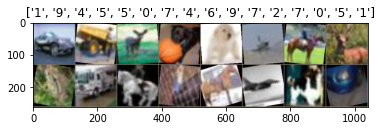

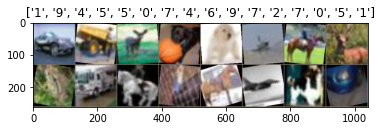

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_23.pth
Epoch = 24, lr = 1.0000000000000002e-06
===> Average Loss: 0.9041688901
===> Average Loss: 0.8455083154
===> Average Loss: 0.8561430890
===> Average Loss: 0.8667109631
===> Average Loss: 0.8619821349
===> Average Loss: 0.8618301967
===> Average Loss: 0.8636374700
===> Average Loss: 0.8685018413
===> Average Loss: 0.8659332816
===> Average Loss: 0.8624946165
===> Average Loss: 0.8649188830
===> Average Loss: 0.8658765672
===> Average Loss: 0.8676813146
===> Average Loss: 0.8663304145
===> Average Loss: 0.8662923351
===> Average Loss: 0.8655349996
===> Average Loss: 0.8661356867
===> Average Loss: 0.8680236125
===> Average Loss: 0.8712524802
===> Average Loss: 0.8722058550
===> Average Loss: 0.8741398623
===> Average Loss: 0.8735462251
===> Average Loss: 0.8717128013
===> Average Loss: 0.8709567929
===> Average Loss: 0.8713095767


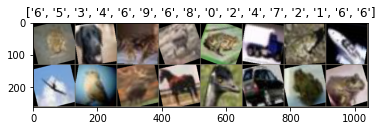

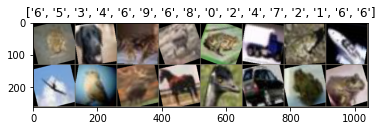

Super resolution network checkpoint saved to /content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_24.pth
Epoch = 25, lr = 1.0000000000000002e-06
===> Average Loss: 0.8954546431
===> Average Loss: 0.8760238943
===> Average Loss: 0.8672846000
===> Average Loss: 0.8730815554
===> Average Loss: 0.8749290668


In [ ]:
# Training settings
parser = argparse.ArgumentParser(description="PyTorch VDSR")
parser.add_argument("--nEpochs", type=int, default=50, help="Number of epochs to train for")
parser.add_argument("--lr", type=float, default=0.0001, help="Learning Rate. Default=0.1")
parser.add_argument("--step", type=int, default=10, help="Sets the learning rate to the initial LR decayed by momentum every n epochs, Default: n=10")
parser.add_argument("--cuda", action="store_true", help="Use cuda?")
parser.add_argument("--resume", default="",type=str, help="Path to checkpoint (default: none)")
parser.add_argument("--start-epoch", default=1, type=int, help="Manual epoch number (useful on restarts)")
parser.add_argument("--clip", type=float, default=0.4, help="Clipping Gradients. Default=0.4")
parser.add_argument("--threads", type=int, default=1, help="Number of threads for data loader to use, Default: 1")
parser.add_argument("--momentum", default=0.9, type=float, help="Momentum, Default: 0.9")
parser.add_argument("--weight-decay", "--wd", default=1e-4, type=float, help="Weight decay, Default: 1e-4")
parser.add_argument('--pretrained_SR', default='/content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_31.pth', type=str, help='path to pretrained model (default: none)')
parser.add_argument('--pretrained_TL', default='/content/drive/MyDrive/checkpoint/TransferLearning/model_CNET_epoch_31.pth', type=str, help='path to pretrained model (default: none)')
parser.add_argument("--gpus", default="0", type=str, help="gpu ids (default: 0)")
parser.add_argument("--pretrained_SR_num", default=0, type=int, help="numbers of epochs that have been trained")
parser.add_argument("--pretrained_TL_num", default=0, type=int, help="numbers of epochs that have been trained")
parser.add_argument("--SRtrain", default=True, help="if train the super resolution network")
parser.add_argument("--TLtrain", default=False, help="if train the trainsfer learning network")
parser.add_argument("--SR_used", default=True, help="if use the SR method thought the pipeline")

def main():
    global opt
    opt = parser.parse_args(args=[])
    print(opt)

    cuda = opt.cuda
    if cuda:
        print("=> use gpu id: '{}'".format(opt.gpus))
        os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpus
        if not torch.cuda.is_available():
                raise Exception("No GPU found or Wrong gpu id, please run without --cuda")

    opt.seed = random.randint(1, 10000)
    print("Random Seed: ", opt.seed)
    torch.manual_seed(opt.seed)
    if cuda:
        torch.cuda.manual_seed(opt.seed)

    cudnn.benchmark = True

    print("===> Loading datasets")
    training_data_loader = dataloaders

    print("===> Building model")
    SRmodel = Net()
    CNET = SDCNN()
    criterion = nn.CrossEntropyLoss()

    print("===> Setting GPU")
    SRmodel = SRmodel.cuda()
    criterion = criterion.cuda()
    CNET = CNET.cuda()

    # optionally resume from a checkpoint
    if opt.resume:
        if os.path.isfile(opt.resume):
            print("=> loading checkpoint '{}'".format(opt.resume))
            checkpoint = torch.load(opt.resume)
            opt.start_epoch = checkpoint["epoch"] + 1
            SRmodel.load_state_dict(checkpoint["model"].state_dict())
        else:
            print("=> no checkpoint found at '{}'".format(opt.resume))

    # optionally copy weights from a checkpoint
    if opt.pretrained_SR:
        if os.path.isfile(opt.pretrained_SR):
            print("=> loading SR model '{}'".format(opt.pretrained_SR))
            weights = torch.load(opt.pretrained_SR)
            SRmodel.load_state_dict(weights['model'].state_dict())
        else:
            print("=> no model found at '{}'".format(opt.pretrained_SR))  
    
    if opt.pretrained_TL:
        if os.path.isfile(opt.pretrained_TL):
            print("=> loading TL model '{}'".format(opt.pretrained_TL))
            weights = torch.load(opt.pretrained_TL)
            #CNET.load_state_dict(weights)
            CNET.load_state_dict(weights['model'].state_dict())
        else:
            print("=> no model found at '{}'".format(opt.pretrained_TL)) 

    print("===> Setting Optimizer")
    optimizer_SR = optim.SGD(SRmodel.parameters(), lr=opt.lr, momentum=opt.momentum, weight_decay=opt.weight_decay)
    #optimizer_TL = optim.SGD(vgg16.fc.parameters(), lr=opt.lr, momentum=opt.momentum, weight_decay=opt.weight_decay)
    #optimizer_TL = optim.SGD(vgg16.parameters(), lr=opt.lr, momentum=opt.momentum, weight_decay=opt.weight_decay)
    optimizer_TL = optim.SGD(CNET.parameters(), lr=opt.lr, momentum=opt.momentum, weight_decay=opt.weight_decay)


    print("===> Training")
    for epoch in range(opt.start_epoch, opt.nEpochs + 1):
        train(dataloaders, optimizer_SR, optimizer_TL, SRmodel, CNET, criterion, epoch)
        if opt.SR_used:
            save_SR_checkpoint(SRmodel, epoch)
        if opt.TLtrain:
            save_TL_checkpoint(CNET, epoch)

def adjust_learning_rate(optimizer_SR, optimizer_TL, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = opt.lr * (0.1 ** (epoch // opt.step))
    return lr

def train(training_data_loader, optimizer_SR, optimizer_TL, SRmodel, CNET, criterion, epoch):
    lr = adjust_learning_rate(optimizer_SR, optimizer_TL, epoch-1)

    for param_group in optimizer_SR.param_groups:
        param_group["lr"] = lr

    for param_group in optimizer_TL.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer_SR.param_groups[0]["lr"]))

    #total = 0  
    #count = 0
    #false = 0

    SRmodel.train()

    total = 0

    for iteration, batch in enumerate(training_data_loader['train'], 1):

      images, labels = Variable(batch[0]), Variable(batch[1], requires_grad=False)
      images = images.cuda()
      labels = labels.cuda()

      if opt.SR_used:
        residual, out_images = SRmodel(images)
        output = CNET(out_images)
      else:
        output = CNET(images)
      
      predicted = output
      #total += labels.size(0)
      #false += (torch.max(predicted.cpu(),1) != labels).sum()
      #count = count+1

      loss = criterion(predicted,labels)
      if opt.SRtrain:
        optimizer_SR.zero_grad()
      if opt.TLtrain:
        optimizer_TL.zero_grad()
      
      loss.backward() 
      nn.utils.clip_grad_norm_(SRmodel.parameters(),opt.clip)
      nn.utils.clip_grad_norm_(CNET.parameters(),opt.clip)

      if opt.SRtrain:
        optimizer_SR.step()
      if opt.TLtrain:
        optimizer_TL.step()

      total += loss.item()

      if iteration%100 == 0:
          print("===> Average Loss: {:.10f}".format(total/iteration))

    if opt.SR_used:
        # Get a batch of training data
        residual, classes = residual.cpu(), labels.cpu()
        inputs = images.cpu()

        # Make a grid from batch
        residual = torchvision.utils.make_grid(residual)
        inp = torchvision.utils.make_grid(inputs)

        imshow(residual, title=[class_names[x] for x in classes])
        imshow(inp, title=[class_names[x] for x in classes])

def imshow(inp, title=None):
      """Imshow for Tensor."""
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)
      if title is not None:
         plt.title(title)
      plt.pause(0.001)  # pause a bit so that plots are updated

def save_SR_checkpoint(SRmodel, epoch):
    model_out_path = "/content/drive/MyDrive/checkpoint/" + "model_SR_CNET_epoch_{}.pth".format(epoch+opt.pretrained_SR_num)
    state = {"epoch": epoch ,"model": SRmodel}
    if not os.path.exists("/content/drive/MyDrive/checkpoint/"):
        os.makedirs("/content/drive/MyDrive/checkpoint/")

    torch.save(state, model_out_path)

    print("Super resolution network checkpoint saved to {}".format(model_out_path))

def save_TL_checkpoint(model, epoch):
    model_out_path = "/content/drive/MyDrive/checkpoint/TransferLearning/" + "model_CNET_epoch_{}.pth".format(epoch+opt.pretrained_TL_num)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("/content/drive/MyDrive/checkpoint/TransferLearning/"):
        os.makedirs("/content/drive/MyDrive/checkpoint/TransferLearning/")

    torch.save(state, model_out_path)

    print("Transfer learning checkpoint saved to {}".format(model_out_path))

if __name__ == "__main__":
    main()

In [ ]:
SRmodel = Net()
CNET = SDCNN()
SRmodel = SRmodel.cuda()
CNET = CNET.cuda()

if opt.pretrained_SR:
    if os.path.isfile(opt.pretrained_SR):
        print("=> loading SR model '{}'".format(opt.pretrained_SR))
        weights = torch.load(opt.pretrained_SR)
        SRmodel.load_state_dict(weights['model'].state_dict())
    else:
        print("=> no model found at '{}'".format(opt.pretrained_SR))  
    
if opt.pretrained_TL:
    if os.path.isfile(opt.pretrained_TL):
        print("=> loading TL model '{}'".format(opt.pretrained_TL))
        weights = torch.load(opt.pretrained_TL)
        CNET.load_state_dict(weights['model'].state_dict())
    else:
        print("=> no model found at '{}'".format(opt.pretrained_TL))

correct = 0
total = 0
for images, labels in dataloaders['test']:
    images = images.cuda()
    if opt.SR_used:
      _,images = SRmodel(images)
    outputs = CNET(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()
    print(predicted, labels, correct, total)
    print("avg acc: %f" % (100* correct/total))

print("avg acc: %f" % (100* correct/total))

=> loading SR model '/content/drive/MyDrive/checkpoint/model_SR_CNET_epoch_48.pth'
=> loading TL model '/content/drive/MyDrive/checkpoint/TransferLearning/model_CNET_epoch_48.pth'


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored